# CIFAR Classifier Module Demo
*Welcome to the demo of our lib CIFAR Classifier !*

A quick summary of what will be showed in this notebook :


1. Imports
2. Data loading and train/test/val separation
3. SIFT features
4. Features extraction
5. Models selection
6. CrossValidation
7. GridSearch
8. Show some results

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from CIFAR_Classif.data_preprocess import load_data, unpickle
from CIFAR_Classif.generic_classifier import GenericClassifier
from CIFAR_Classif.generic_features_extractor import GenericFeaturesExtractor
from CIFAR_Classif.metrics import benchmark_models, benchmark_feature_extractors
from CIFAR_Classif.bovw import get_SIFT_kp_and_desc, get_bovw_features, reduce_descs_dimensions
from sklearn.model_selection import train_test_split, cross_val_score
import cv2
from sklearn.cluster import KMeans


### Data loading and train/test/val separation

In [2]:
path_list = ['../data/cifar-10-batches-py/data_batch_5', '../data/cifar-10-batches-py/data_batch_4', '../data/cifar-10-batches-py/data_batch_3',
             '../data/cifar-10-batches-py/data_batch_2', '../data/cifar-10-batches-py/data_batch_1']

meta_path = '../data/cifar-10-batches-py/batches.meta'

labels_meaning = unpickle(meta_path)[b'label_names'] # List of the labels
labels_meaning = [label.decode('utf-8') for label in labels_meaning] # We turn the binary strings into normal strings


# Load the data
X, y = load_data(path_list, apply_preprocess=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42) # 15% of the data for testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42) # 30% of 85% of the data for validation

### SIFT Features

Here we illustrate our SIFT features on a picture

In [18]:
train_keypoints, train_descriptors = get_SIFT_kp_and_desc(X_train, dim_out=64)
test_keypoints, test_descriptors = get_SIFT_kp_and_desc(X_test, dim_out=64)


/home/spottedbush/.virtualenvs/cifar_classif/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/spottedbush/.virtualenvs/cifar_classif/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


/home/spottedbush/.virtualenvs/cifar_classif/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/spottedbush/.virtualenvs/cifar_classif/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


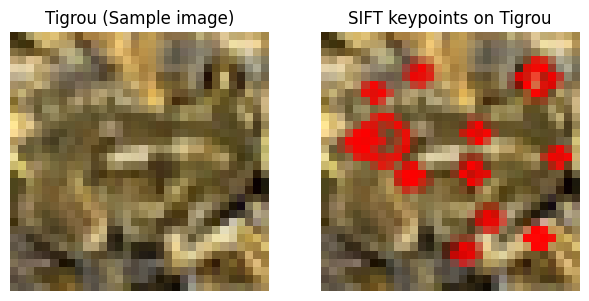

In [11]:
img = X_train[0]
plt.subplot(1, 3, 1)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title('Tigrou (Sample image)')
plt.axis('off')

sift_kp_img = cv2.drawKeypoints(img, train_keypoints[0], 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(1, 3, 2)
plt.imshow(sift_kp_img, cmap='gray')
plt.title('SIFT keypoints on Tigrou')
plt.axis('off')

plt.subplots_adjust(right=1.5)
plt.show()

## Features extraction

We chose to use the following feature extractors:
- Histogram of Gradient (HoG)
- Local Binary Pattern (LBP)
- SIFT

But using benchmark_feature_extractors we found out that only one proved to be relevant : HoG (Feature selection proved to drastically down our results so we won't enable it)

In [3]:
hog = GenericFeaturesExtractor("hog")

hog_features_train = hog.extract_features(X_train, features_selection=False)
hog_features_test = hog.extract_features(X_test, features_selection=False)

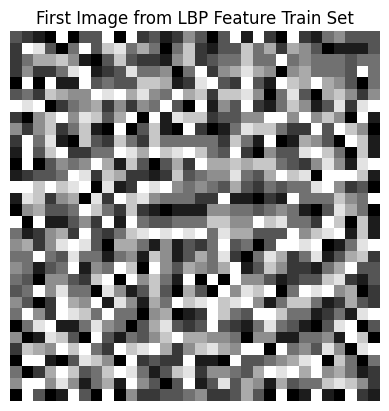

In [10]:
lbp = GenericFeaturesExtractor("lbp")

lbp_features_train = lbp.extract_features(X_train, features_selection=False)
lbp_features_test = lbp.extract_features(X_test, features_selection=False)
# Get the first image from the LBP feature train set
first_image = lbp_features_train[0]

# Plot the image
plt.imshow(first_image, cmap='gray')
plt.axis('off')
plt.title('First Image from LBP Feature Train Set')
plt.show()

## Models selection

We are comparing results from three different classifiers:

- SVC that is non-parametric and non linear.
- Logistic Regression that is parametric and linear.
- KNN that is non parametric and non linear.

In [4]:
accuracy, report = benchmark_models(hog_features_train, y_train, hog_features_test, y_test, model_list=["svc", "logistic_regression", "knn"])

------svc------
Accuracy: 0.502
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.64      0.58       148
           1       0.64      0.61      0.62       170
           2       0.43      0.32      0.37       138
           3       0.39      0.36      0.38       144
           4       0.40      0.49      0.44       151
           5       0.47      0.36      0.41       140
           6       0.46      0.69      0.55       134
           7       0.47      0.45      0.46       146
           8       0.60      0.58      0.59       173
           9       0.60      0.50      0.54       156

    accuracy                           0.50      1500
   macro avg       0.50      0.50      0.49      1500
weighted avg       0.50      0.50      0.50      1500

------logistic_regression------


/home/spottedbush/.virtualenvs/cifar_classif/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.42533333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.48      0.48       148
           1       0.57      0.53      0.55       170
           2       0.35      0.27      0.30       138
           3       0.35      0.25      0.29       144
           4       0.34      0.40      0.37       151
           5       0.39      0.26      0.31       140
           6       0.37      0.57      0.45       134
           7       0.38      0.43      0.40       146
           8       0.51      0.51      0.51       173
           9       0.50      0.50      0.50       156

    accuracy                           0.43      1500
   macro avg       0.42      0.42      0.42      1500
weighted avg       0.43      0.43      0.42      1500

------knn------
Accuracy: 0.2906666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.28      0.35       148
           

## CrossValidation

Let's check that we haven't overfit our model with a CrossValidation: (we only checked SVC because it is our best model)

In [27]:
svc = GenericClassifier(kernel="svc")
svc.set_parameters({'C':0.1, 'kernel':'poly'})
scores = cross_val_score(svc.kernel, hog_features_train, y_train, cv=6)  # X and y are your input features and target variable
print("Cross-validation scores:", scores)
mean_score = scores.mean()
print("Mean accuracy:", mean_score)

Cross-validation scores: [0.4233871  0.4516129  0.42540323 0.41633065 0.43289606 0.44500505]
Mean accuracy: 0.43243916349294187


Good news, it seems that our results aren't overfitted !
(We lost some accuracy because our train sample got smaller)

## Grid Search

Since SVC seems to be our best model, we are going to do a GridSearch in order to know its optimal hyer-parameters

In [7]:
# Define the parameter grid
param_grid = {'C': [0.0001,0.001,0.01,0.1,1,10,100]}

svc = GenericClassifier(kernel='svc')
svc.set_parameters({'kernel': 'poly'})
grid_search = svc.grid_search(param_grid, hog_features_train, y_train, verbose=True)

print(f"Best parameters: {grid_search.best_params_}, best score: {grid_search.best_score_}")

Best Parameters: {'C': 0.1}
Best Score: 0.4322689075630253
Best parameters: {'C': 0.1}, best score: 0.4322689075630253


## Metrics

In [8]:
from CIFAR_Classif.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

svc = GenericClassifier(kernel='svc')
svc.set_parameters({'C':0.1, 'kernel': 'poly'})
svc.fit(hog_features_train, y_train)
y_pred = svc.predict(hog_features_test)
y_true = y_test


Now some metrics on our SVC to understand well our results

Confusion matrix

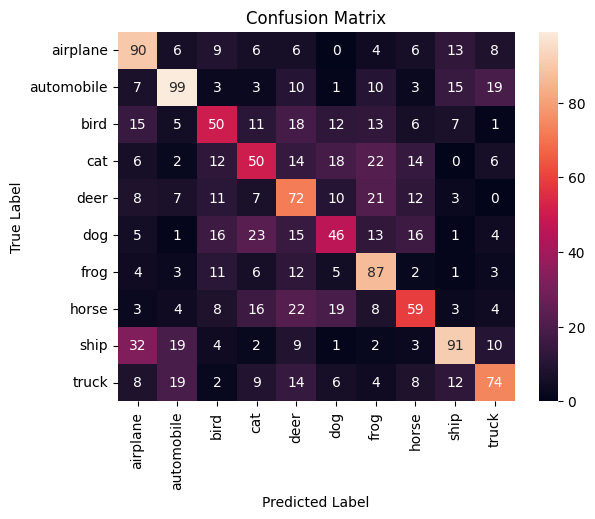

In [9]:
plot_confusion_matrix(y_true, y_pred, labels=labels_meaning)

Precision Recall Curve

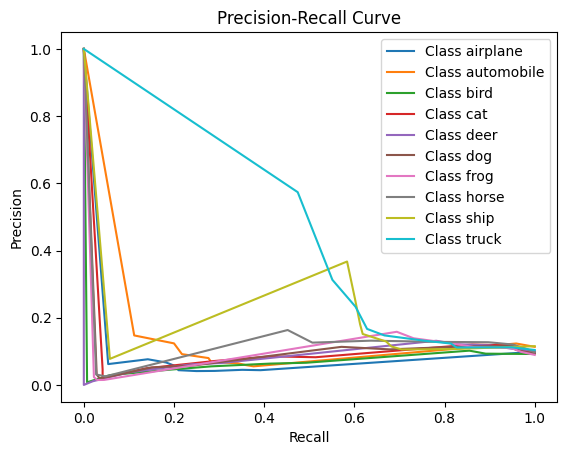

In [10]:
plot_precision_recall_curve(y_true, y_pred, labels=labels_meaning)

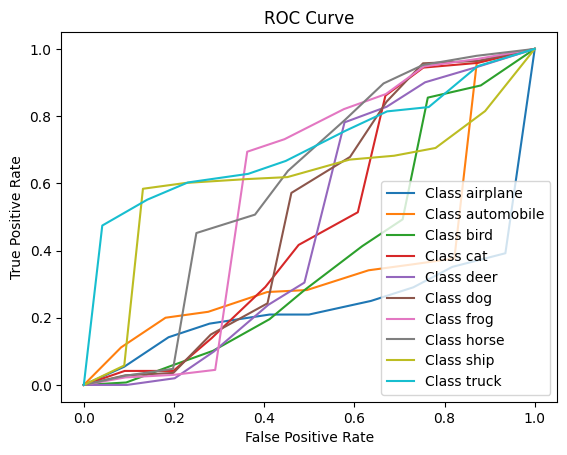

In [11]:
plot_roc_curve(y_true, y_pred, labels=labels_meaning)